In [6]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
# from ipdb import set_trace as st

In [ ]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cuda")  # Set to CPU

K = 70

def data_gen(BATCH_SIZE):
    # 8 Gaussians
    while True:
        theta = (np.pi / 4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
        centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
        noise = torch.randn_like(centers) * 0.1
        yield centers + noise

test_loader = train_loader = data_gen(args.batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, 25)
        self.fc22 = nn.Linear(K, 25)
        self.fc3 = nn.Linear(25, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)Tune
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

In [13]:
train_loss_list = []
test_loss_list = []
test_data = next(data_gen(2048))
# Training loop
for epoch in range(1, args.epochs + 1):     
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    train_loss_list.append(train_loss)
    recon_batch_test, mu_test, logvar_test = model(test_data)
    test_loss = loss_function(recon_batch_test, test_data, mu_test, logvar_test).item()
    test_loss_list.append(test_loss)
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}, Testing Loss: {test_loss}')

Epoch: 1, Training Loss: 0.11971926972270013, Testing Loss: 0.11817654967308044
Epoch: 2, Training Loss: 0.11949301272630691, Testing Loss: 0.11935730278491974
Epoch: 3, Training Loss: 0.11986678779125214, Testing Loss: 0.11656811833381653
Epoch: 4, Training Loss: 0.1197211554646492, Testing Loss: 0.11830077320337296
Epoch: 5, Training Loss: 0.11980523772537709, Testing Loss: 0.1197144091129303
Epoch: 6, Training Loss: 0.11977503001689911, Testing Loss: 0.11982589215040207
Epoch: 7, Training Loss: 0.11961732111871243, Testing Loss: 0.11747243255376816
Epoch: 8, Training Loss: 0.11974029392004013, Testing Loss: 0.11898528039455414
Epoch: 9, Training Loss: 0.11960368223488331, Testing Loss: 0.119156114757061
Epoch: 10, Training Loss: 0.11962236940860749, Testing Loss: 0.11814476549625397
Epoch: 11, Training Loss: 0.11964787147939206, Testing Loss: 0.12008350342512131
Epoch: 12, Training Loss: 0.11971237957477569, Testing Loss: 0.11690640449523926
Epoch: 13, Training Loss: 0.1196146494895

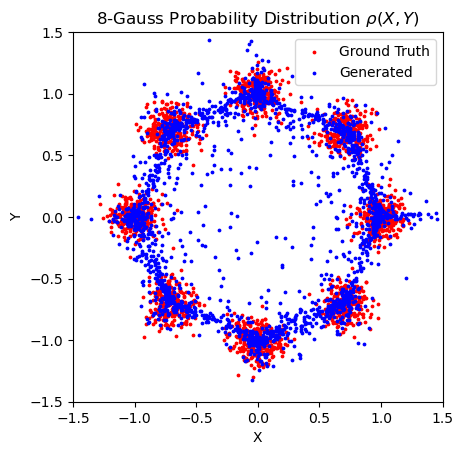

In [12]:
# Visualization
gt = next(train_loader)
with torch.no_grad():
    sample = torch.randn(2048, 25).to(device)
    out = model.decode(sample).cpu().numpy()
    recon = model(gt)[0].cpu().numpy()

rx, ry = recon[:, 0], recon[:, 1]
gt = gt.cpu().numpy()
gx, gy = gt[:, 0], gt[:, 1]
xs, ys = out[:, 0], out[:, 1]

plt.scatter(gx, gy, c='red', s=3, label='Ground Truth')
plt.scatter(xs, ys, c='blue', s=3, label='Generated')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'8-Gauss Probability Distribution $\rho(X,Y)$')
plt.legend()
plt.show()

In [7]:
train_loss_list = []
test_loss_list = []
test_data = next(data_gen(2048))
# Training loop
for epoch in range(1, args.epochs + 1):     
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    train_loss_list.append(train_loss)
    recon_batch_test, mu_test, logvar_test = model(test_data)
    test_loss = loss_function(recon_batch_test, test_data, mu_test, logvar_test).item()
    test_loss_list.append(test_loss)
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}, Testing Loss: {test_loss}')

Epoch: 1, Training Loss: 0.23601196438074112, Testing Loss: 0.1644189953804016
Epoch: 2, Training Loss: 0.14676609709858895, Testing Loss: 0.14158856868743896
Epoch: 3, Training Loss: 0.14235917136073112, Testing Loss: 0.14074186980724335
Epoch: 4, Training Loss: 0.1401740048825741, Testing Loss: 0.13567033410072327
Epoch: 5, Training Loss: 0.13717265516519547, Testing Loss: 0.13371217250823975
Epoch: 6, Training Loss: 0.1337256522476673, Testing Loss: 0.131655752658844
Epoch: 7, Training Loss: 0.13019219309091568, Testing Loss: 0.12574131786823273
Epoch: 8, Training Loss: 0.12683031655848026, Testing Loss: 0.12471373379230499
Epoch: 9, Training Loss: 0.12439193114638329, Testing Loss: 0.12114918231964111
Epoch: 10, Training Loss: 0.12262126184999943, Testing Loss: 0.11923140287399292
Epoch: 11, Training Loss: 0.12203259162604808, Testing Loss: 0.12024037539958954
Epoch: 12, Training Loss: 0.12162989050149918, Testing Loss: 0.12053453922271729
Epoch: 13, Training Loss: 0.12117276147007

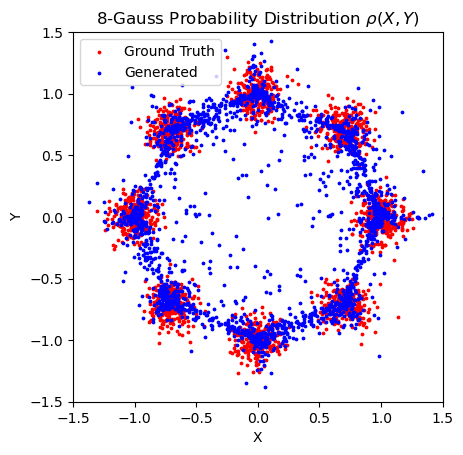

In [8]:
# Visualization
gt = next(train_loader)
with torch.no_grad():
    sample = torch.randn(2048, 25).to(device)
    out = model.decode(sample).cpu().numpy()
    recon = model(gt)[0].cpu().numpy()

rx, ry = recon[:, 0], recon[:, 1]
gt = gt.cpu().numpy()
gx, gy = gt[:, 0], gt[:, 1]
xs, ys = out[:, 0], out[:, 1]

plt.scatter(gx, gy, c='red', s=3, label='Ground Truth')
plt.scatter(xs, ys, c='blue', s=3, label='Generated')
plt.gca().set_aspect('equal', adjustable='box')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.xlabel('X')
plt.ylabel('Y')
plt.title(r'8-Gauss Probability Distribution $\rho(X,Y)$')
plt.legend()
plt.show()

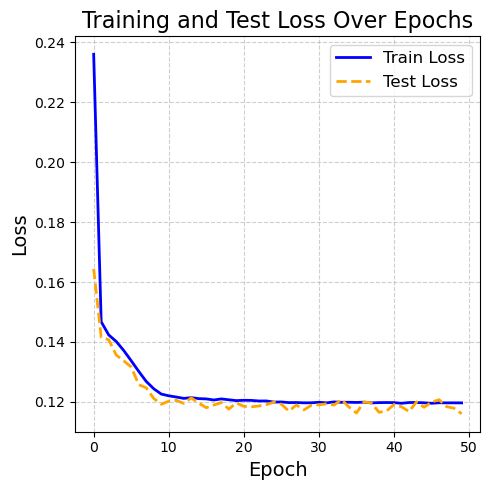

In [20]:
plt.figure(figsize=(5, 5))  # Set the figure size
plt.plot(train_loss_list, label='Train Loss', linewidth=2, color='blue', linestyle='-')
plt.plot(test_loss_list, label='Test Loss', linewidth=2, color='orange', linestyle='--')
plt.xlabel('Epoch', fontsize=14)
plt.ylabel('Loss', fontsize=14)
plt.title('Training and Test Loss Over Epochs', fontsize=16)
plt.legend(fontsize=12)
plt.grid(True, linestyle='--', alpha=0.6)
plt.tight_layout()  # Adjust the padding
plt.show()

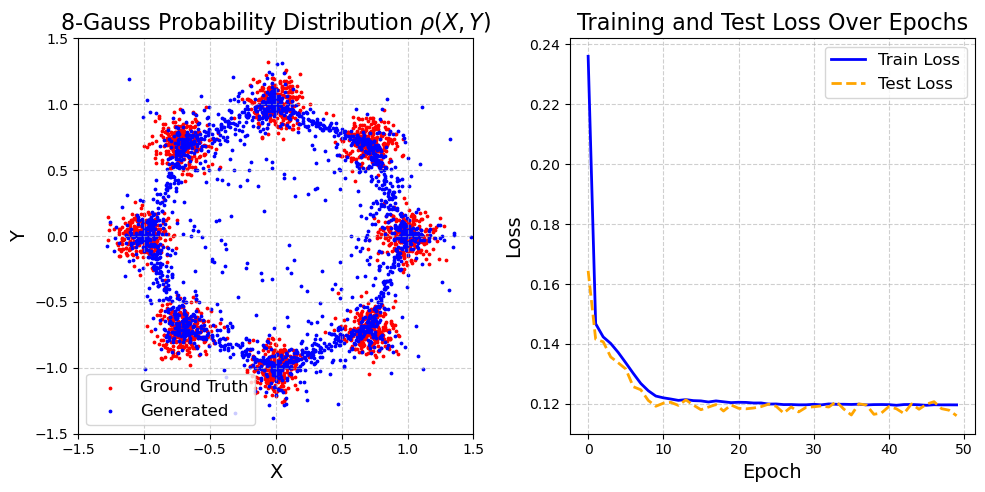

In [24]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))  # Create a figure with two subplots side by side

# Left plot: Scatter plot for Ground Truth and Generated data
axes[0].scatter(gx, gy, c='red', s=3, label='Ground Truth')
axes[0].scatter(xs, ys, c='blue', s=3, label='Generated')
axes[0].set_aspect('equal', adjustable='box')
axes[0].set_xlim(-1.5, 1.5)
axes[0].set_ylim(-1.5, 1.5)
axes[0].set_xlabel('X', fontsize=14)
axes[0].set_ylabel('Y', fontsize=14)
axes[0].set_title(r'8-Gauss Probability Distribution $\rho(X,Y)$', fontsize=16)
axes[0].legend(fontsize=12)
axes[0].grid(True, linestyle='--', alpha=0.6)

# Right plot: Line plot for Training and Test Loss
axes[1].plot(train_loss_list, label='Train Loss', linewidth=2, color='blue', linestyle='-')
axes[1].plot(test_loss_list, label='Test Loss', linewidth=2, color='orange', linestyle='--')
axes[1].set_xlabel('Epoch', fontsize=14)
axes[1].set_ylabel('Loss', fontsize=14)
axes[1].set_title('Training and Test Loss Over Epochs', fontsize=16)
axes[1].legend(fontsize=12)
axes[1].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plots
plt.tight_layout()  # Adjust the padding to fit the plots nicely
plt.show()

In [12]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cpu")  # Set to CPU

K = 70

def data_gen(BATCH_SIZE):
    # 8 Gaussians
    while True:
        trans = torch.ones((BATCH_SIZE, 2), device=device)
        theta = (np.pi / 4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
        centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
        noise = torch.randn_like(centers) * 0.1
        yield centers + noise - trans

test_loader = train_loader = data_gen(args.batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 +1.2*KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

Epoch: 1, Training Loss: 0.27219088837504385
Epoch: 2, Training Loss: 0.1229982053488493
Epoch: 3, Training Loss: 0.09481370784342288
Epoch: 4, Training Loss: 0.08602521307766438
Epoch: 5, Training Loss: 0.07791304305195808
Epoch: 6, Training Loss: 0.07706836879253387
Epoch: 7, Training Loss: 0.07642234414815903
Epoch: 8, Training Loss: 0.0756912399828434
Epoch: 9, Training Loss: 0.07492192938923836
Epoch: 10, Training Loss: 0.0740444067120552
Epoch: 11, Training Loss: 0.07327303655445576
Epoch: 12, Training Loss: 0.0724259638786316
Epoch: 13, Training Loss: 0.07172935374081135
Epoch: 14, Training Loss: 0.0708383273333311
Epoch: 15, Training Loss: 0.06993198715150356
Epoch: 16, Training Loss: 0.0691538130491972
Epoch: 17, Training Loss: 0.0683774460107088
Epoch: 18, Training Loss: 0.06774893805384635
Epoch: 19, Training Loss: 0.06710180118680001
Epoch: 20, Training Loss: 0.06657379925251007
Epoch: 21, Training Loss: 0.06623703353106976
Epoch: 22, Training Loss: 0.0657947202771902
Epoch

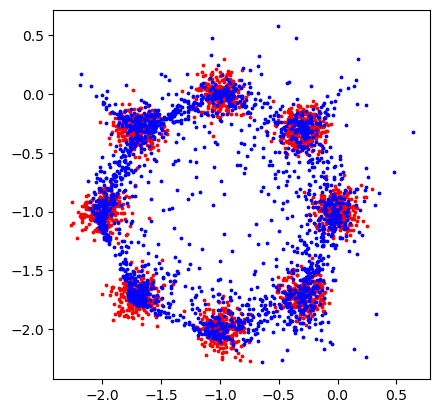

In [102]:
if __name__ == "__main__":
    # Training loop
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    # Visualization
    gt = next(train_loader)
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx, ry = recon[:, 0], recon[:, 1]
    gt = gt.cpu().numpy()
    gx, gy = gt[:, 0], gt[:, 1]
    xs, ys = out[:, 0], out[:, 1]

    plt.scatter(gx, gy, c='red', s=3)
    plt.scatter(xs, ys, c='blue', s=3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [96]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=50, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cpu")  # Set to CPU

K = 50

def data_gen(BATCH_SIZE):
    # 8 Gaussians
    while True:
        trans = torch.ones((BATCH_SIZE, 2), device=device)
        # theta = (np.pi / 4) * torch.randint(0, 8, (BATCH_SIZE,)).float().to(device)
        theta = (np.pi / 4) * torch.ones((BATCH_SIZE,)).float().to(device)
        centers = torch.stack((torch.cos(theta), torch.sin(theta)), dim=-1)
        noise = torch.randn_like(centers)
        yield centers + noise + trans*4

test_loader = train_loader = data_gen(args.batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 +1.2*KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

Epoch: 1, Training Loss: 3.145905354619026
Epoch: 2, Training Loss: 0.6825687670707703
Epoch: 3, Training Loss: 0.5902293747663498
Epoch: 4, Training Loss: 0.5051770821213722
Epoch: 5, Training Loss: 0.42137705385684965
Epoch: 6, Training Loss: 0.3444260010123253
Epoch: 7, Training Loss: 0.2750327362120151
Epoch: 8, Training Loss: 0.21633242174983025
Epoch: 9, Training Loss: 0.17497387558221816
Epoch: 10, Training Loss: 0.1522756114602089
Epoch: 11, Training Loss: 0.14593247637152673
Epoch: 12, Training Loss: 0.14114543691277504
Epoch: 13, Training Loss: 0.13798215016722679
Epoch: 14, Training Loss: 0.13523788437247275
Epoch: 15, Training Loss: 0.13322092726826668
Epoch: 16, Training Loss: 0.13079449713230132
Epoch: 17, Training Loss: 0.1291398911178112
Epoch: 18, Training Loss: 0.127076618373394
Epoch: 19, Training Loss: 0.12544464580714704
Epoch: 20, Training Loss: 0.12384382672607899
Epoch: 21, Training Loss: 0.12220369510352612
Epoch: 22, Training Loss: 0.12079613484442234
Epoch: 2

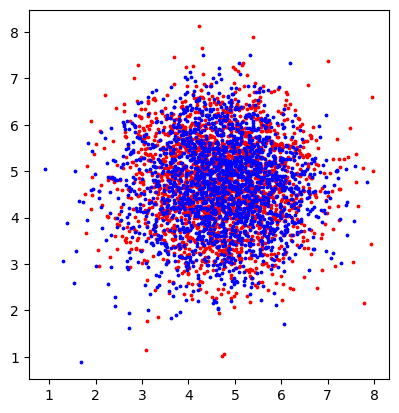

In [97]:
if __name__ == "__main__":
    # Training loop
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    # Visualization
    gt = next(train_loader)
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx, ry = recon[:, 0], recon[:, 1]
    gt = gt.cpu().numpy()
    gx, gy = gt[:, 0], gt[:, 1]
    xs, ys = out[:, 0], out[:, 1]

    plt.scatter(gx, gy, c='red', s=3)
    plt.scatter(xs, ys, c='blue', s=3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [94]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=30, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cpu")  # Set to CPU

K = 50

# def data_gen(BATCH_SIZE):
#     while True:
#         trans = torch.ones((BATCH_SIZE, 2), device=device)
#         centers = torch.zeros((BATCH_SIZE, 2), device=device)
#         noise = torch.randn_like(centers)*0.5
#         yield centers + noise + trans*2

# test_loader = train_loader = data_gen(args.batch_size)

def data_gen(batch_size):
    while True:
        samples = []
        labels = []
        
        # Generate the samples and labels
        # for i in range(4):  # Four classes
            # for j in range(int(batch_size / 4)):  # Divide the batch equally among the four classes
                # samples.append([np.random.normal(0, 1) + i, np.random.normal(0, 1)])  # Shift by i
                # labels.append(i)  # Class label
        
        for j in range(int(batch_size)):  # Divide the batch equally among the four classes
            samples.append([np.random.normal(0, 1), np.random.normal(0, 1)])  # Shift by i
            labels.append(0)  # Class label        
        
        # Zip them together and shuffle
        combined = list(zip(samples, labels))
        random.shuffle(combined)
        
        # Unzip them after shuffling
        shuffled_samples, shuffled_labels = zip(*combined)
        shuffled_samples = torch.tensor(shuffled_samples, dtype=torch.float32)
        shuffled_labels = torch.tensor(shuffled_labels, dtype=torch.long)

        # yield shuffled_samples, shuffled_labels
        yield shuffled_samples
    
test_loader = train_loader = data_gen(args.batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x):
        h1 = F.selu(self.fc1(F.selu(self.fc0(x))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(z)))))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 2))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + 0.4*KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

Epoch: 1, Training Loss: 0.24219618275761604
Epoch: 2, Training Loss: 0.12717741958796977
Epoch: 3, Training Loss: 0.08606200903654099
Epoch: 4, Training Loss: 0.06719199743121862
Epoch: 5, Training Loss: 0.05195310451090336
Epoch: 6, Training Loss: 0.05042957466095686
Epoch: 7, Training Loss: 0.04996509831398725
Epoch: 8, Training Loss: 0.04962709996849299
Epoch: 9, Training Loss: 0.04934508215636015
Epoch: 10, Training Loss: 0.04910084508359432
Epoch: 11, Training Loss: 0.04890786848962307
Epoch: 12, Training Loss: 0.04882597304880619
Epoch: 13, Training Loss: 0.048543885089457034
Epoch: 14, Training Loss: 0.048437234945595264
Epoch: 15, Training Loss: 0.048382239192724226
Epoch: 16, Training Loss: 0.048220278471708296
Epoch: 17, Training Loss: 0.04824042182415724
Epoch: 18, Training Loss: 0.04813306413590908
Epoch: 19, Training Loss: 0.048039748072624205
Epoch: 20, Training Loss: 0.0480106508359313
Epoch: 21, Training Loss: 0.04797725141048431
Epoch: 22, Training Loss: 0.04790242712

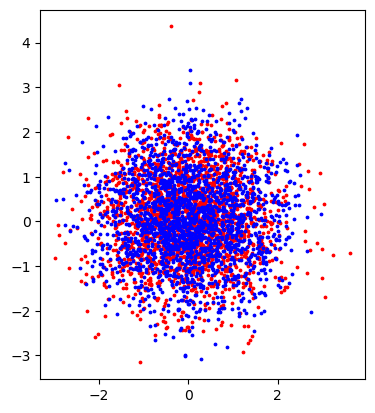

In [95]:
if __name__ == "__main__":
    # Training loop
    for epoch in range(1, args.epochs + 1):
        train(epoch)

    # Visualization
    gt = next(train_loader)
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        out = model.decode(sample).cpu().numpy()
        recon = model(gt)[0].cpu().numpy()

    rx, ry = recon[:, 0], recon[:, 1]
    gt = gt.cpu().numpy()
    gx, gy = gt[:, 0], gt[:, 1]
    xs, ys = out[:, 0], out[:, 1]

    plt.scatter(gx, gy, c='red', s=3)
    plt.scatter(xs, ys, c='blue', s=3)
    plt.gca().set_aspect('equal', adjustable='box')
    plt.show()

In [120]:
mu, logvar = model.encode(next(train_loader))
z = model.reparameterize(mu, logvar)

In [123]:
z = z.cpu().detach()
z = np.array(z)
z.shape

(2048, 2)

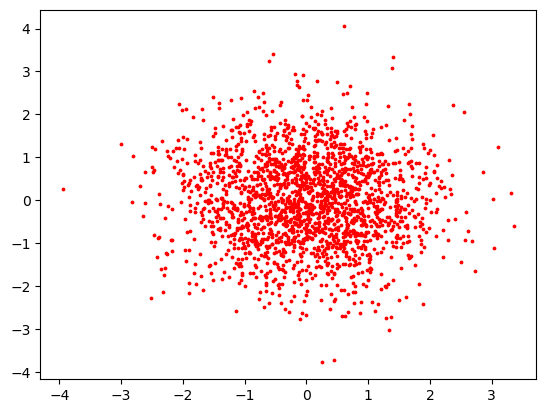

In [125]:
plt.scatter(z[:,0], z[:,1], c='red', s=3)

In [126]:
sample = torch.randn(2048, K).to(device)
sample.cpu().detach()
sample = np.array(sample)
sample.shape

(2048, 2)

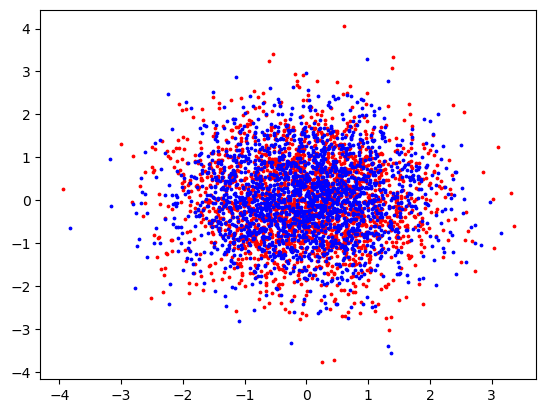

In [177]:
plt.scatter(z[:,0], z[:,1], c='red', s=3)
plt.scatter(sample[:,0], sample[:,1], c='blue', s=3)

In [58]:
number = torch.nn.functional.one_hot(torch.tensor(1), num_classes=5).to(device)

In [59]:
number

tensor([0, 1, 0, 0, 0])

In [67]:
def data_gen(BATCH_SIZE):
    while True:
        trans = torch.ones((BATCH_SIZE, 2), device=device)
        centers = torch.zeros((BATCH_SIZE, 2), device=device)
        noise = torch.randn_like(centers)*0.5
        yield centers + noise + trans
x = next(data_gen(10))

In [68]:
x.shape

torch.Size([10, 2])

In [90]:
samples = []
labels = []
for i in range(4):
    for j in range(int(args.batch_size/4)):
        samples.append( [np.random.normal(0,1)+i, np.random.normal(0,1)] )
        labels.append(i)
combined = list(zip(samples, labels))
random.shuffle(combined)
shuffled_samples, shuffled_labels = zip(*combined)
shuffled_samples = np.array(shuffled_samples)
shuffled_samples = np.array(shuffled_samples)

In [86]:
samples.shape

(2048, 2)

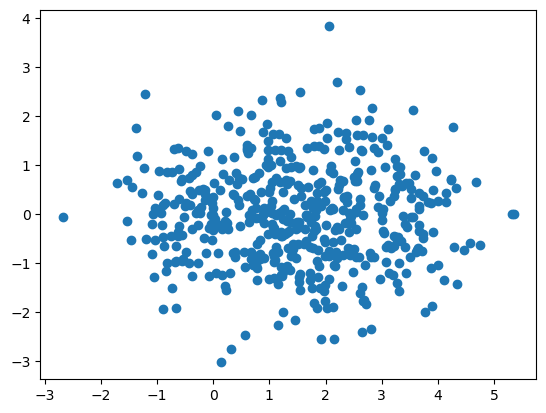

In [91]:
plt.scatter(shuffled_samples[:512,0], shuffled_samples[:512,1])

In [161]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=30, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cpu")  # Set to CPU

K = 50
num_class = 5

def data_gen(batch_size):
    while True:
        samples = []
        labels = []
        
        # Generate the samples and labels
        for i in range(num_class):  # Four classes
            for j in range(int(batch_size / num_class)):  # Divide the batch equally among the four classes
                samples.append([np.random.normal(0, 1) + i, np.random.normal(0, 1)])  # Shift by i
                labels.append(i)  # Class label      
        
        # Zip them together and shuffle
        combined = list(zip(samples, labels))
        random.shuffle(combined)
        
        # Unzip them after shuffling
        shuffled_samples, shuffled_labels = zip(*combined)
        shuffled_samples = torch.tensor(shuffled_samples, dtype=torch.float32)
        shuffled_labels = torch.tensor(shuffled_labels, dtype=torch.long)

        yield shuffled_samples, shuffled_labels
    
test_loader = train_loader = data_gen(args.batch_size)

class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()
        self.fc0 = nn.Linear(2+num_class, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K+num_class, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x, y):
        h1 = F.selu(self.fc1(F.selu(self.fc0(torch.cat((x,y),dim=1)))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(torch.cat((z,y),dim=1))))))

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 2), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

# Initialize model, optimizer, and scheduler
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + 0.4*KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data_x = data[0].to(device)
        data_y = F.one_hot(data[1], num_classes=num_class)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_x, data_y)
        loss = loss_function(recon_batch, data_x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

In [162]:
if __name__ == "__main__":
    # Training loop
    for epoch in range(1, args.epochs + 1):
        train(epoch)

Epoch: 1, Training Loss: 0.7471477064490318
Epoch: 2, Training Loss: 0.2442028234899044
Epoch: 3, Training Loss: 0.16823643192648888
Epoch: 4, Training Loss: 0.12188495978713036
Epoch: 5, Training Loss: 0.09331825740635395
Epoch: 6, Training Loss: 0.07485549606382846
Epoch: 7, Training Loss: 0.07120582759380341
Epoch: 8, Training Loss: 0.06886651009321212
Epoch: 9, Training Loss: 0.06588306691497564
Epoch: 10, Training Loss: 0.05607161987572908
Epoch: 11, Training Loss: 0.052927591912448405
Epoch: 12, Training Loss: 0.05205277007073164
Epoch: 13, Training Loss: 0.05147835835814476
Epoch: 14, Training Loss: 0.050971416980028154
Epoch: 15, Training Loss: 0.05042388066649437
Epoch: 16, Training Loss: 0.04998057063668966
Epoch: 17, Training Loss: 0.04965550314635039
Epoch: 18, Training Loss: 0.049444052651524545
Epoch: 19, Training Loss: 0.04920131824910641
Epoch: 20, Training Loss: 0.04912128277122974
Epoch: 21, Training Loss: 0.048918509706854824
Epoch: 22, Training Loss: 0.0488268187642

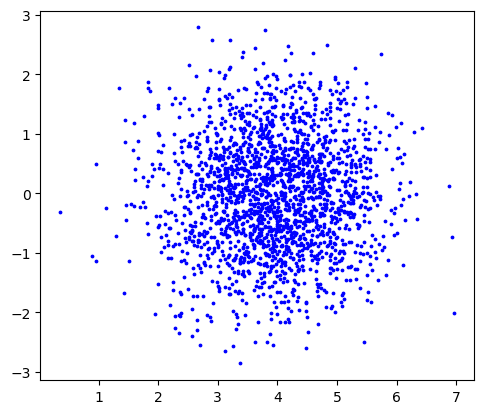

In [163]:
# Visualization
gt = next(train_loader)
with torch.no_grad():
    sample = torch.randn(2048, K).to(device)
    label  = 4*torch.ones(2048, dtype=torch.long).to(device)
    label  = F.one_hot(label, num_classes=num_class)
    out = model.decode(sample, label).cpu().numpy()

gt = gt[0].cpu().numpy()
gx, gy = gt[:, 0], gt[:, 1]
xs, ys = out[:, 0], out[:, 1]

# plt.scatter(gx, gy, c='red', s=3)
plt.scatter(xs, ys, c='blue', s=3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

In [25]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import numpy as np
import matplotlib.pyplot as plt 
import random
from ipdb import set_trace as st

In [47]:
import sys
sys.argv = [sys.argv[0]]

# Argument parser setup
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=2048, metavar='N',
                    help='input batch size for training (default: 128)')
parser.add_argument('--epochs', type=int, default=30, metavar='N',
                    help='number of epochs to train (default: 10)')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
args = parser.parse_args()

# Set seed and device
torch.manual_seed(args.seed)
device = torch.device("cpu")  # Set to CPU

K = 50
num_class = 6

def data_gen(batch_size):
    while True:
        samples = []
        labels = []
        
        # Generate the samples and labels
        for i in range(num_class):  # Four classes
            #if i != 3 and i != 4:
                for j in range(int(batch_size / num_class-2)):  # Divide the batch equally among the four classes
                    samples.append([np.random.normal(0, 0.5) + i, np.random.normal(0, 0.5)])  # Shift by i
                    labels.append(i)  # Class label      
        
        # Zip them together and shuffle
        combined = list(zip(samples, labels))
        random.shuffle(combined)
        
        # Unzip them after shuffling
        shuffled_samples, shuffled_labels = zip(*combined)
        shuffled_samples = torch.tensor(shuffled_samples, dtype=torch.float32)
        shuffled_labels = torch.tensor(shuffled_labels, dtype=torch.long)

        yield shuffled_samples, shuffled_labels
    
test_loader = train_loader = data_gen(args.batch_size)

In [27]:
class eCVAE(nn.Module):
    def __init__(self):
        super(eCVAE, self).__init__()
        
        self.embedding_dims = 5
        self.num_class = 6
        self.embed_cond = nn.Embedding(num_embeddings=self.num_class, embedding_dim=self.embedding_dims, max_norm=True)
        
        self.fc0 = nn.Linear(2+self.embedding_dims, K)
        self.fc1 = nn.Linear(K, K)
        self.fc21 = nn.Linear(K, K)
        self.fc22 = nn.Linear(K, K)
        self.fc3 = nn.Linear(K+self.embedding_dims, K)
        self.fc4 = nn.Linear(K, K)
        self.fc5 = nn.Linear(K, 2)

    def encode(self, x, y):
        h1 = F.selu(self.fc1(F.selu(self.fc0(torch.cat((x,self.embed_cond(y)),dim=1)))))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y):
        return self.fc5(F.selu(self.fc4(F.selu(self.fc3(torch.cat((z,self.embed_cond(y)),dim=1))))))

    def forward(self, x, y):
        mu, logvar = self.encode(x.view(-1, 2), y)
        z = self.reparameterize(mu, logvar)
        return self.decode(z, y), mu, logvar

In [48]:
model = eCVAE().to(device)
optimizer = optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True, threshold=1E-2, eps=1e-6)

# Loss function
def loss_function(recon_x, x, mu, logvar):
    L2 = torch.mean((recon_x - x) ** 2)
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp())
    return L2 + KLD

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data_x = data[0].to(device)
        data_y = data[1]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_x, data_y)
        loss = loss_function(recon_batch, data_x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

In [49]:
for epoch in range(1, args.epochs + 1):
    train(epoch)

Epoch: 1, Training Loss: 0.9007622984051704
Epoch: 2, Training Loss: 0.3172887368500233
Epoch: 3, Training Loss: 0.16383344285190105
Epoch: 4, Training Loss: 0.11777507275342941
Epoch: 5, Training Loss: 0.10765307508409024
Epoch: 6, Training Loss: 0.09789220474660397
Epoch: 7, Training Loss: 0.08583372183144093
Epoch: 8, Training Loss: 0.08022730775177479
Epoch: 9, Training Loss: 0.077512496560812
Epoch: 10, Training Loss: 0.07604501895606518
Epoch: 11, Training Loss: 0.0752683100104332
Epoch: 12, Training Loss: 0.0748480811715126
Epoch: 13, Training Loss: 0.07443144649267197
Epoch: 14, Training Loss: 0.07415223501622677
Epoch: 15, Training Loss: 0.07392688177525997
Epoch: 16, Training Loss: 0.07379944734275341
Epoch: 17, Training Loss: 0.07353362604975701
Epoch: 18, Training Loss: 0.07339674092829228
Epoch: 19, Training Loss: 0.07323925882577896
Epoch: 20, Training Loss: 0.07310862608253955
Epoch: 21, Training Loss: 0.07280873060226441
Epoch: 22, Training Loss: 0.07281723327934742
Epo

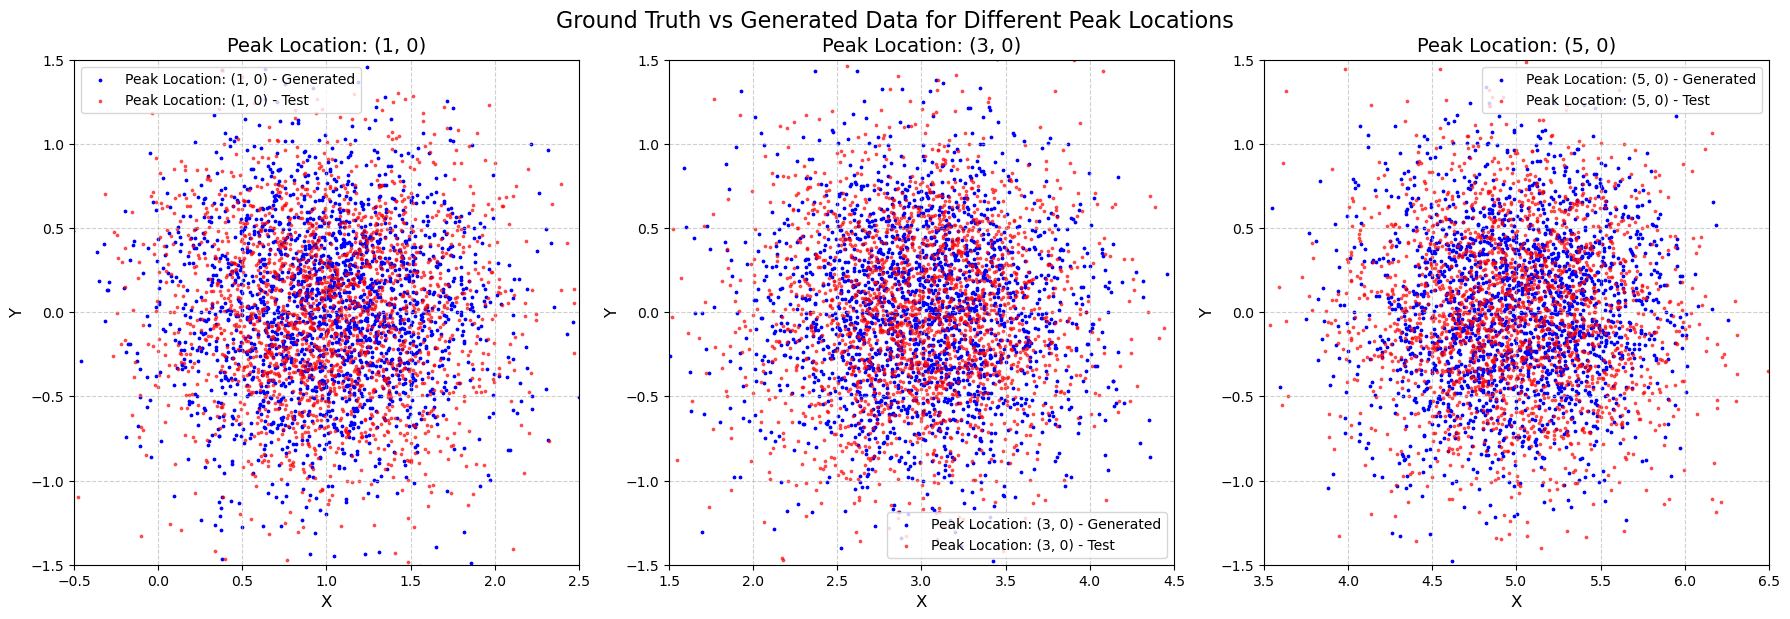

In [64]:
conditions = [1, 3, 5]
labels = [f'Peak Location: ({x}, 0)' for x in conditions]

fig, axes = plt.subplots(1, 3, figsize=(18, 6))  # Create a figure with three subplots in a row

# Loop over each condition
for i, condition in enumerate(conditions):
    # Generate test data
    test_data_list = []
    for _ in range(2048):
        test_data_list.append([np.random.normal(0, 0.5) + condition, np.random.normal(0, 0.5)])

    # Convert the list to a NumPy array and extract test_x, test_y
    test_data_array = np.array(test_data_list)
    test_x = test_data_array[:, 0]
    test_y = test_data_array[:, 1]

    # Generate model output
    with torch.no_grad():
        sample = torch.randn(2048, K).to(device)
        label = condition * torch.ones(2048, dtype=torch.long).to(device)
        out = model.decode(sample, label).cpu().numpy()

    xs, ys = out[:, 0], out[:, 1]

    # Plot the generated and test data on the ith subplot
    axes[i].scatter(xs, ys, c='blue', s=3, label=f'{labels[i]} - Generated')
    axes[i].scatter(test_x, test_y, c='red', s=3, alpha=0.6, label=f'{labels[i]} - Test')

    # Set plot settings for each subplot to ensure consistency
    axes[i].set_aspect('equal', adjustable='box')
    axes[i].set_xlim(condition - 1.5, condition + 1.5)  # Dynamic x-axis limits around the peak
    axes[i].set_ylim(-1.5, 1.5)  # Fixed y-axis limits
    axes[i].set_xlabel('X', fontsize=12)
    axes[i].set_ylabel('Y', fontsize=12)
    axes[i].set_title(labels[i], fontsize=14)
    axes[i].legend(fontsize=10)
    axes[i].grid(True, linestyle='--', alpha=0.6)

# Adjust layout and show the plots
plt.tight_layout()  # Adjust the padding between and around subplots
plt.suptitle('Ground Truth vs Generated Data for Different Peak Locations', fontsize=16, y=1.02)  # Set a common title
plt.show()


In [16]:
for name, param in model.named_parameters():
    if name == 'embed_cond.weight':
        param.requires_grad = True
    else:
        param.requires_grad = False

In [17]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embed_cond.weight: True
fc0.weight: False
fc0.bias: False
fc1.weight: False
fc1.bias: False
fc21.weight: False
fc21.bias: False
fc22.weight: False
fc22.bias: False
fc3.weight: False
fc3.bias: False
fc4.weight: False
fc4.bias: False
fc5.weight: False
fc5.bias: False


In [18]:
def data_gen_more(batch_size):
    while True:
        samples = []
        labels = []
        
        # Generate the samples and labels
        for j in range(int(batch_size / num_class)):
            samples.append([np.random.normal(0, 0.5) + 3, np.random.normal(0, 0.5)])  # Shift by i
            labels.append(3)  # Class label      
        
        # Zip them together and shuffle
        combined = list(zip(samples, labels))
        random.shuffle(combined)
        
        # Unzip them after shuffling
        shuffled_samples, shuffled_labels = zip(*combined)
        shuffled_samples = torch.tensor(shuffled_samples, dtype=torch.float32)
        shuffled_labels = torch.tensor(shuffled_labels, dtype=torch.long)

        yield shuffled_samples, shuffled_labels

In [26]:
more = next(data_gen_more(2048))

In [19]:
test_loader = train_loader = data_gen_more(args.batch_size)
def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, data in enumerate(train_loader):
        if batch_idx > 100:
            break  # 100 batches per epoch
        data_x = data[0].to(device)
        data_y = data[1]
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data_x, data_y)
        loss = loss_function(recon_batch, data_x, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
    train_loss /= 100
    scheduler.step(train_loss)
    print(f'Epoch: {epoch}, Training Loss: {train_loss}')

In [20]:
for epoch in range(1, args.epochs + 1):
    train(epoch)

Epoch: 1, Training Loss: 0.09989210918545723
Epoch: 2, Training Loss: 0.08205086030066014
Epoch: 3, Training Loss: 0.08066017024219035
Epoch: 4, Training Loss: 0.07951947137713432
Epoch: 5, Training Loss: 0.0786815945804119
Epoch: 6, Training Loss: 0.07708575554192067
Epoch: 7, Training Loss: 0.07664326630532742
Epoch: 8, Training Loss: 0.07602330580353737
Epoch: 9, Training Loss: 0.07563518978655338
Epoch: 10, Training Loss: 0.0755299711227417
Epoch: 11, Training Loss: 0.07546644628047944
Epoch: 12, Training Loss: 0.07524273253977298
Epoch: 13, Training Loss: 0.075129199847579
Epoch: 14, Training Loss: 0.07502702869474888
Epoch: 15, Training Loss: 0.0750481779128313
Epoch: 16, Training Loss: 0.07514742128551007
Epoch: 17, Training Loss: 0.0750919260084629
Epoch: 18, Training Loss: 0.07481927506625652
Epoch: 19, Training Loss: 0.07454627998173237
Epoch: 20, Training Loss: 0.07435545794665814
Epoch: 21, Training Loss: 0.07488041780889035
Epoch: 22, Training Loss: 0.0744882744550705
Epoc

In [34]:
for name, param in model.named_parameters():
    print(f"{name}: {param.requires_grad}")

embed_cond.weight: True
fc0.weight: False
fc0.bias: False
fc1.weight: False
fc1.bias: False
fc21.weight: False
fc21.bias: False
fc22.weight: False
fc22.bias: False
fc3.weight: False
fc3.bias: False
fc4.weight: False
fc4.bias: False
fc5.weight: False
fc5.bias: False


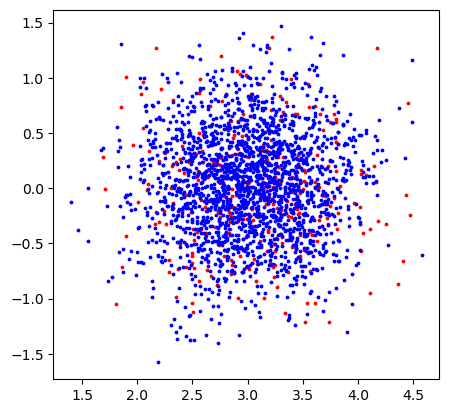

In [21]:
# Visualization
gt = next(train_loader)
with torch.no_grad():
    sample = torch.randn(2048, K).to(device)
    label  = 3*torch.ones(2048, dtype=torch.long).to(device)
    out = model.decode(sample, label).cpu().numpy()

gt = gt[0].cpu().numpy()
gx, gy = gt[:, 0], gt[:, 1]
xs, ys = out[:, 0], out[:, 1]

plt.scatter(gx, gy, c='red', s=3)
plt.scatter(xs, ys, c='blue', s=3)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()